In [1]:
%matplotlib widget
%load_ext autoreload
%autoreload 2
%load_ext snakeviz

import sys
sys.path.append("/usr/wrk/people9/sima9999/code/")

import psutil
import time
import os
import logging

import numpy as np
import scipy.stats

from uncertainty.polymorphic_uncertainty import RandomVariable, MassFunction, PolyUQ
from helpers import get_pcd

import glob
import matplotlib
import matplotlib.pyplot as plt

%aimport -sys -logging -matplotlib -matplotlib.pyplot -numpy -pandas - scipy.stats -scipy.stats.qmc -ray

In [2]:
def example_a():
    print('Pure stochastic example...')
    example_num = 0
    q1 = RandomVariable(name='q1', dist='norm', params=[15, 4], primary=True)
    q2 = RandomVariable(name='q2', dist='norm', params=[8, 2], primary=True)
    
    dim_ex='hadamard'
    
    vars_ale = [q1,q2]
    vars_epi = []
    return example_num, dim_ex, vars_ale, vars_epi,
    

In [3]:
def example_b():
    print('Imprecision (probability-based intervals) example...')
    example_num = 1
    
    inc_q1a1 = (RandomVariable(name='q1', dist='norm', params=[15,4], primary=False), # set same name to share input samples
               )
    inc_q1a0 = (inc_q1a1[0],
                RandomVariable(name='q1a0l', dist='norm', params=[-0.4,0.1], primary=False), 
                RandomVariable(name='dq1a0r', dist='norm', params=[0.5,0.06], primary=False))
    q1 = MassFunction(name='q1', focals=[inc_q1a1, inc_q1a0], masses=[0.5,0.5], primary=True, incremental=True)
    
    inc_q2a1 = (RandomVariable(name='q2', dist='norm', params=[8,2], primary=False), # set same name to share input samples
               )
    inc_q2a0 = (inc_q2a1[0],
                RandomVariable(name='dq2a0l', dist='norm', params=[-0.6,0.08], primary=False), 
                RandomVariable(name='dq2a0r', dist='norm', params=[0.4,0.11], primary=False))
    q2 = MassFunction(name='q2', focals=[inc_q2a1, inc_q2a0], masses=[0.5,0.5], primary=True, incremental=True)
    
    dim_ex='hadamard'
    
    vars_ale = [*inc_q1a0,*inc_q2a0]
    vars_epi = [q1, q2]
    return example_num, dim_ex, vars_ale, vars_epi,
    

In [4]:
def example_c():
    print('Incompleteness (interval-based randomness) example...')
    example_num = 2
    mu1 = MassFunction(name='mu1', focals=[(14.79,14.79),(13.96,15.61)], masses=[0.5,0.5], primary=False)
    sig1 = MassFunction(name='sig1', focals=[(4.17,4.17),(3.66,4.85)], masses = [0.5, 0.5], primary=False)
    q1 = RandomVariable(name='q1', dist='norm', params=[mu1, sig1])
    
    mu2 = MassFunction(name='mu2', focals=[(8.1,8.1),(7.67,8.52)], masses=[0.5,0.5], primary=False)
    sig2 = MassFunction(name='sig2', focals=[(2.14,2.14),(1.88,2.48)], masses = [0.5, 0.5], primary=False)
    q2 = RandomVariable(name='q2', dist='norm', params=[mu2, sig2])
    
    dim_ex='hadamard'
    
    vars_epi = [mu1,sig1, mu2, sig2]
    vars_ale = [q1, q2]
    return example_num, dim_ex, vars_ale, vars_epi,
    

In [20]:
def example_d():
    print('Incompleteness+Imprecision (interval probability-based random intervals) example...')
    example_num = 3
    q1a1mu    = MassFunction(name='q1a1mu',    focals=[(14.62, 14.62), (13.8, 15.45)], masses=[0.5,0.5],  primary=False)
    q1a1sig   = MassFunction(name='q1a1sig',   focals=[(4.16 ,  4.16), (3.65, 4.83)], masses=[0.5,0.5],   primary=False)
    q1a1      = RandomVariable(name='q1',    dist='norm', params=[q1a1mu, q1a1sig], primary=False)
    
    dq1a0lmu  = MassFunction(name='dq1a0lmu',  focals=[(-0.41, -0.41), (-0.46, -0.38)], masses=[0.5,0.5],  primary=False)
    dq1a0lsig = MassFunction(name='dq1a0lsig', focals=[( 0.10,  0.10), ( 0.09,  0.12)], masses=[0.5,0.5],  primary=False)
    dq1a0l    = RandomVariable(name='dq1a0l',  dist='norm', params=[dq1a0lmu, dq1a0lsig], primary=False)
    
    dq1a0rmu  = MassFunction(name='dq1a0rmu',  focals=[( 0.50, 0.50 ), ( 0.49,  0.52)], masses=[0.5,0.5],  primary=False)
    dq1a0rsig = MassFunction(name='dq1a0sig',  focals=[( 0.06, 0.06 ), ( 0.05,  0.08)], masses=[0.5,0.5],  primary=False)
    dq1a0r    = RandomVariable(name='dq1a0r',  dist='norm', params=[dq1a0rmu, dq1a0rsig], primary=False)
    
    q1        = MassFunction(name='q1', focals=[(q1a1, 0, 0), (q1a1, dq1a0l, dq1a0r)], masses=[0.5,0.5], primary=True, incremental=True)
    
    q2a1mu    = MassFunction(name='q2a1mu',   focals=[(8.10, 8.10   ), (7.67, 8.52)], masses=[0.5,0.5],  primary=False)
    q2a1sig   = MassFunction(name='q2a1sig',  focals=[(2.12, 2.12   ), (1.86, 2.46)], masses=[0.5,0.5],   primary=False)
    q2a1      = RandomVariable(name='q2',   dist='norm', params=[q2a1mu, q2a1sig], primary=False)
    
    dq2a0lmu  = MassFunction(name='dq2a0lmu',  focals=[(-0.59, -0.59), (-0.61, -0.57)], masses=[0.5,0.5],  primary=False)
    dq2a0lsig = MassFunction(name='dq2a0lsig', focals=[( 0.08,  0.08), ( 0.07,  0.09)], masses=[0.5,0.5],  primary=False)
    dq2a0l    = RandomVariable(name='dq2a0l',  dist='norm', params=[dq2a0lmu, dq2a0lsig], primary=False)
    
    dq2a0rmu  = MassFunction(name='dq2a0rmu',  focals=[(0.40, 0.40), (0.38, 0.42)], masses=[0.5,0.5],  primary=False)
    dq2a0rsig = MassFunction(name='dq2a0sig',  focals=[(0.10, 0.10), (0.09, 0.12)], masses=[0.5,0.5],  primary=False)
    dq2a0r    = RandomVariable(name='dq2a0r',  dist='norm', params=[dq2a0rmu, dq2a0rsig], primary=False)
    
    q2        = MassFunction(name='q2', focals=[(q2a1, 0, 0), (q2a1, dq2a0l, dq2a0r)], masses=[0.5,0.5], primary=True, incremental=True)
    
    dim_ex='hadamard'
    
    vars_epi = [q1a1mu, q1a1sig, dq1a0lmu, dq1a0lsig, dq1a0rmu, dq1a0rsig, q1,
                q2a1mu, q2a1sig, dq2a0lmu, dq2a0lsig, dq2a0rmu, dq2a0rsig, q2]
    vars_ale = [q1a1, dq1a0l, dq1a0r,
                q2a1, dq2a0l, dq2a0r,]
    return example_num, dim_ex, vars_ale, vars_epi,

In [6]:
def example_e():
    print('Mixed Imprecision and Incompleteness example...')
    example_num = 4
    mu1 = MassFunction(name='mu1', focals=[(14.79,14.79),(13.96,15.61)], masses=[0.5,0.5], primary=False)
    sig1 = MassFunction(name='sig1', focals=[(4.17,4.17),(3.66,4.85)], masses = [0.5, 0.5], primary=False)
    q1 = RandomVariable(name='q1', dist='norm', params=[mu1, sig1])
    
    inc_q2a1 = (RandomVariable(name='q2', dist='norm', params=[8,2], primary=False),) # set same name to share input samples
    inc_q2a0 = (inc_q2a1[0],
                RandomVariable(name='dq2a0l', dist='norm', params=[-0.6,0.08], primary=False), 
                RandomVariable(name='dq2a0r', dist='norm', params=[0.4,0.11], primary=False))
    q2 = MassFunction(name='q2', focals=[inc_q2a1, inc_q2a0], masses=[0.5,0.5], primary=True, incremental=True)
    
    dim_ex='hadamard'
    vars_epi = [mu1,sig1, q2]
    vars_ale = [q1, *inc_q2a0]
    
    return example_num, dim_ex, vars_ale, vars_epi,

In [8]:
def deterministic_mapping2(q1,q2):
    return (189/500*q1+3*q2)*16/3
arg_vars = {'q1':'q1', 'q2':'q2'}

def stat_fun(a, weight, i_stat, minmax):
    exceed = a>=260
    return np.sum(weight[exceed])

example_num = 3
# N_mcs = int(10**(float(sys.argv[2])/8))
N_mcs=100
# 2 - 7 in steps of 0.125 -> 100...1333521 -> 16...50


result_dir = '/usr/scratch4/sima9999/work/modal_uq/uq_simple_beam/'
if not os.path.exists(result_dir):
    os.makedirs(result_dir)

In [ ]:
def qmc_uq(N_mcs, example_num, run_num, **kwargs):
    if example_num==4:
        N_mcs_ = np.floor(np.sqrt(N_mcs)).astype(int) # that makes N_mcs == fcount
    else:
        N_mcs_ = N_mcs
    
    _, dim_ex, vars_ale, vars_epi, = [example_a, example_b, example_c, example_d, example_e][example_num]()
    
    this_result_dir = os.path.join(result_dir, f'{example_num}-{N_mcs}/{run_num}/')
    if not os.path.exists(this_result_dir):
        os.makedirs(this_result_dir)
                                       
    prop_path = os.path.join(this_result_dir, 'polyuq_prop.npz')
    imp_path = os.path.join(this_result_dir, 'polyuq_imp.npz')
    inc_path = os.path.join(this_result_dir, 'polyuq_inc.npz')
    
    print(imp_path, this_result_dir)
    poly_uq = PolyUQ(vars_ale, vars_epi, dim_ex=dim_ex)

    logger = logging.getLogger('uncertainty.polymorphic_uncertainty')
    logger.setLevel(level=logging.INFO)
    
    # if 'start_ale' in kwargs:
    try:
        poly_uq.load_state(prop_path)
        asd
    # else:
    except:
        poly_uq.sample_qmc(N_mcs_, N_mcs_, percentiles=(0.000001, 0.999999), check_discr=False)
        poly_uq.propagate(deterministic_mapping2, arg_vars)
        poly_uq.save_state(prop_path)
    # return
    if os.path.exists(imp_path) and False:
        
        poly_uq.load_state(imp_path, differential='imp')
    else:
        poly_uq.estimate_imp(
            interp_fun='nearest',
            opt_meth='Powell',
            plot_res=False,
            plot_intp=False,
            intp_err_warn = None,
            extrp_warn = 10,
            # kernel='gaussian',
            # epsilon=2
            **kwargs
            )

        if 'start_ale' in kwargs:
            start_ale = kwargs['start_ale']
            imp_path = os.path.join(this_result_dir, f'polyuq_imp_{start_ale}.npz')
            poly_uq.save_state(imp_path, differential='imp')
            return

        poly_uq.save_state(imp_path, differential='imp')
    
    focals_Pf, hyc_mass = poly_uq.optimize_inc(stat_fun, 1)
    poly_uq.save_state(inc_path, differential='inc')

    return example_num, N_mcs, focals_Pf

N_mcs = int(1e6)
example_num = 4
run_num = 0
# qmc_uq(N_mcs, example_num, run_num)
for example_num in [4,]:
    for run_num in range(30):
        _,_, focals_Pf = qmc_uq(N_mcs, example_num, run_num)
        display(focals_Pf*1e4)
# _,_, focals_Pf = qmc_uq(N_mcs, example_num, run_num)
# display(focals_Pf*1e4)

In [ ]:
# merge partial results from distributed computations
for example_num in [1]:
    # continue
    print('exnum',example_num)
    for run_num in range(30):
        print('runnum',run_num)
        for MCS_exponent in range(6,7):
            N_mcs = int(10**(float(MCS_exponent)))
            this_result_dir = os.path.join(result_dir, f'{example_num}-{N_mcs}/{run_num}/')
            N_parts = 50
            parts = np.linspace(0,N_mcs,N_parts+1, dtype=int)
            
            imp_path = os.path.join(this_result_dir, f'polyuq_imp_{parts[0]}.npz')
            in_dict = dict(np.load(imp_path, allow_pickle=True))
            imp_foc = in_dict['self.imp_foc']
            val_samp_prim = in_dict.get('self.val_samp_prim')
            intp_errors = in_dict.get('self.intp_errors')
            intp_exceed = in_dict.get('self.intp_exceed')
            intp_undershot = in_dict.get('self.intp_undershot')
            
            for part in range(1,N_parts):
                print('part',part)
                start_ale = parts[part]
                end_ale = parts[part+1]
                this_imp_path = os.path.join(this_result_dir, f'polyuq_imp_{parts[part]}.npz')
                this_in_dict = np.load(this_imp_path, allow_pickle=True)
                this_imp_foc = this_in_dict['self.imp_foc']
                this_val_samp_prim = this_in_dict.get('self.val_samp_prim')
                this_intp_errors = this_in_dict.get('self.intp_errors')
                this_intp_exceed = this_in_dict.get('self.intp_exceed')
                this_intp_undershot = this_in_dict.get('self.intp_undershot')
                
                imp_foc[start_ale:end_ale,:,:] = this_imp_foc[start_ale:end_ale,:,:]
                assert not np.all(np.isnan(imp_foc[start_ale:end_ale,:,:]))
                
                val_samp_prim[start_ale:end_ale,...] = this_val_samp_prim[start_ale:end_ale,...]
                intp_errors[start_ale:end_ale] = this_intp_errors[start_ale:end_ale]
                
                intp_exceed[0] += this_intp_exceed[0]
                intp_exceed[1] += this_intp_exceed[1]
                
                intp_undershot[0] += this_intp_undershot[0]
                intp_undershot[1] += this_intp_undershot[1]
            
            
            in_dict['self.imp_foc'] = imp_foc
            in_dict['self.val_samp_prim'] = val_samp_prim
            in_dict['self.intp_errors'] = intp_errors
            in_dict['self.intp_exceed'] = intp_exceed
            in_dict['self.intp_undershot'] = intp_undershot
            
            imp_path = os.path.join(this_result_dir, f'polyuq_imp.npz')
            np.savez_compressed(imp_path, **in_dict)
            

In [9]:
'''
the mapping is linear in both variables
the statistic is the number of samples exceeding a threshold
it is monotonic increasing with both variables
if any variable is a random variable
the statistic increases with increasing mean and increasing sigma

so to obtain the minimum (maximum) extract the minima (maxima) from all focal sets in a given hypercube, sample and estimate statistic
'''

def naive_uq(N_mcs, example_num, run_num):
    
    _, dim_ex, vars_ale, vars_epi, = [example_a, example_b, example_c, example_d, example_e][example_num]()
    # 1 3 4
    poly_uq = PolyUQ(vars_ale, vars_epi, dim_ex=dim_ex)
    
    weight = np.ones((N_mcs))/N_mcs
    
    vars_imp = poly_uq.vars_imp
    vars_inc = poly_uq.vars_inc
    vars_ale = poly_uq.vars_ale

    vars_prim = {var.name:var for var in poly_uq.all_vars.values() if var.primary}

    imp_hyc_foc_inds = poly_uq.imp_hyc_foc_inds
    inc_hyc_foc_inds = poly_uq.inc_hyc_foc_inds
    
    n_imp_hyc = len(imp_hyc_foc_inds)
    n_inc_hyc = len(inc_hyc_foc_inds)
    
    n_hyc = n_imp_hyc * n_inc_hyc
    n_stat, i_stat = 1, 0
    
    focals_stats = np.full((n_stat, n_hyc, 4), np.nan)
    
    inc_numeric_focals = [var.numeric_focals for var in vars_inc]
    for i_hyc_inc, hyc_inc in enumerate(inc_hyc_foc_inds):# no-inc runs a single time
        if hyc_inc:
            inc_focals = np.vstack([focals[ind,:] for focals, ind in zip(inc_numeric_focals, hyc_inc)])
            if np.all(inc_focals[:,0]==inc_focals[:,1]):
                inc_focals = inc_focals[:,0:1]
        else:
            inc_focals = np.empty((0,1))

        for inc_min_max in range(inc_focals.shape[1]):
            # extract min_max from from incompleteness focal sets
            for foc,var in zip(inc_focals, vars_inc):
                # set distribution parameters = freeze inc variables
                var.freeze(foc[inc_min_max])
            # sample aleatory variables
            rvs_ale = np.empty((len(vars_ale),N_mcs))
            for i_var, var in enumerate(vars_ale):
                rvs_ale[i_var,:] = var.rvs(N_mcs)

            for i_hyc_imp, hyc_imp in enumerate(imp_hyc_foc_inds):# no-imp runs a single time
                if hyc_imp:
                    len_focals = []
                    for i_var, var in enumerate(vars_imp):
                        focals = var._focals[hyc_imp[i_var]]
                        lenf = 3 - np.sum(np.logical_or([x is np.nan for x in focals], focals==0))
                        # print(var, focals, lenf, np.logical_or(focals==np.nan, focals==0), focals==np.nan)
                        len_focals.append(lenf)
                    # print(len_focals, np.all(np.array(len_focals)==1))
                    if np.all(np.array(len_focals)==1):
                        mm_range = range(1)
                    else:
                        mm_range = range(2)
                else:
                    mm_range = range(1)
                for imp_min_max in mm_range:
                    rvs_prim = np.empty((2, N_mcs))

                    for n_ale in range(N_mcs):
                        # set random values = freeze ale variables
                        for i_var, var in enumerate(vars_ale):
                            var.freeze(rvs_ale[i_var, n_ale])
                        # extract min_max from imprecision focal sets
                        for i_var, var in enumerate(vars_imp):
                            var.freeze(var.numeric_focal(hyc_imp[i_var])[0,imp_min_max])
                        # assemble primary variables
                        for i_var, var_name in enumerate(['q1', 'q2']):
                            rvs_prim[i_var, n_ale] = vars_prim[var_name].value
                    out_samp = deterministic_mapping2(rvs_prim[0,:], rvs_prim[1,:])
                    
                    # compute statistic
                    stat  = stat_fun(out_samp, weight, None, None) * 1e4
                    focals_stats[i_stat, i_hyc_imp*n_inc_hyc + i_hyc_inc, imp_min_max*2 + inc_min_max] = stat
                    
                    alpha = ['1  ',["0,l","0,r"][imp_min_max]][i_hyc_imp]
                    beta  = ['1  ',["0,l","0,r"][inc_min_max]][i_hyc_inc]
                    print(f' P_{{f,α={alpha}}},  P_{{f,β={beta}}} => stat {stat}')
                    print(i_stat, i_hyc_imp*n_inc_hyc + i_hyc_inc, imp_min_max*2 + inc_min_max)
                    
    this_result_dir = os.path.join(result_dir, f'{example_num}-{N_mcs}/{run_num}/')
    if not os.path.exists(this_result_dir):
        os.makedirs(this_result_dir)
        
    save_path = os.path.join(this_result_dir, 'naive_uq.npz')
    np.savez(save_path, focals_stats)
    
    return focals_stats

N_mcs = int(1e6)
example_num = 3
run_num = 0

# naive_uq(N_mcs, example_num, run_num)

Compute all examples with pure MCS and 

establish confidence bounds from multiple runs (or bootstrap?)

document results in a table (internal use for thesis not for paper)

Run all examples with polyUQ and

establish confidence bounds form multiple runs

document results in a table (for paper)

redo convergence study (internal use for thesis not for paper)

Include example in Polymorphic Uncertainty section of paper

description and clarification: fuzzy alpha-level cuts represented by mass functions

Problem: differential variables make the problem more complicated

only include the "corners" of example (d)

add an example section after each paragraph, outlining the variables and values w.r.t. the algorithms 1-4



In [10]:
def analyze(example_num, hyc_num=None):
    files = glob.glob(f'/vegas/scratch/womo1998/modal_uq/convergence_PolyUQ/{example_num}_*')
    if not files: return
    
    N_mcss = []
    focals = []
    fcounts = []
    mems = []
    runtimes = []
    for file in files:
        N_mcss.append(int(file.split('_')[-2].strip('.npz')))
        arr = np.load(file, allow_pickle=True)
        focals.append(arr['focals_Pf'])
        fcounts.append(arr['fcount'].item())
        mems.append(arr['mem'].item())
        runtimes.append(arr['runtime'].item())
        
    # plt.plot(N_mcss, runtimes, ls='none', marker='.')
    # plt.show()
    fcounts=np.array(fcounts)
    N_mcss=np.array(N_mcss)
    fcounts=N_mcss
    
    
    
    focals = np.stack(focals)
    n_hyc = focals.shape[2]
    if example_num==0:
        it_hyc = [0]
        ref = [[1.003e-3],]
        color='#377eb8'
    elif example_num==1:
        it_hyc = [0,1]
        ref = [[10.27e-4],
               [3.21e-4,21.94e-4]]
        color='#4daf4a'
    elif example_num==2:
        it_hyc = [0,1]
        ref = [[20.10e-4],
               [2.33e-4,120.16e-4]]
        color='#ff7f00'
    elif example_num==3:
        it_hyc = [0,1,2,3]
        
        ref = [[19.12e-4],
               [1.66e-4,111.55e-4],
               [7.6e-4,37.07e-4],
               [0.54e-4,183.12e-4],
               ]
        color='#e41a1c'
    elif example_num==4:
        it_hyc = [0,1,2,3,4,5,6,7]
        
        ref = [[None], # complete, precise
               [None,None], # partly incomplete, precise
               [None,None], # partly incomplete, precise
               [None,None], # incomplete, precise
               [None,None], # complete, imprecise
               [None,None], # partly incomplete, imprecise
               [None,None], # partly incomplete, imprecise
               [None,None], #incomplete, imprecise
               ]
        color='#984ea3'
    # print(focals.shape)
    
    '''
    
    compute relative error for each sample
    compute confidence interval for each fcount
    plot fill_between
    
    '''
    
    for i,i_hyc in enumerate(it_hyc):
        if hyc_num is not None:
            if hyc_num!=i_hyc: continue
        for high_low in range(len(ref[i])):
            unique = np.unique(fcounts)
            unique = unique[unique>=1e3]
            conf= np.zeros((len(unique),2))
            if ref[i][high_low] is None:
            # if True:
                ref[i][high_low] = np.mean(focals[fcounts==np.max(unique),0,i_hyc,high_low])
            print(f'Ex {example_num} Hyc {i_hyc} u/l {high_low}')
            print(np.mean(focals[fcounts==np.max(unique),0,i_hyc,high_low]), ref[i][high_low])
            for j in range(len(unique)):
                
                inds = fcounts==unique[j]
                # print(f'Ex {example_num} Hyc {i_hyc} u/l {high_low} Nmcs {unique[j]}; samples: {np.sum(inds)}')
                data = focals[inds,0,i_hyc,high_low]
                data -= ref[i][high_low]
                data /= ref[i][high_low]
                data *= 100
                data = np.abs(data)
                
                conf[j,:] = scipy.stats.t.interval(alpha=0.95, df=len(data)-1, loc=np.mean(data), scale=scipy.stats.sem(data)) 
            
            plt.fill_between(unique, conf[:,0], conf[:,1], alpha=0.5, color=color, ls=['solid','dashed'][high_low])
            
        
        plt.xscale('log')
    # plt.axhline(1, c='grey', lw=.5)
    # plt.show()

In [11]:
def analyze2():
    '''
    group into (example, hyc) 
    '''
    with matplotlib.rc_context(rc=get_pcd()):
        fig, axes = plt.subplots(2,2,sharex=True, sharey='col')
        axes = axes.ravel()
        
        for n in [0,1,2,3,]:
        # for n in [3,]:
            plt.sca(axes[n])
            if n == 0:
                datasets = [[0, 0], [1, 0], [2, 0], [3, 0], [4, 0]]  # pure variability
                title = 'variability (var)'
            elif n == 1:
                datasets = [ [3, 2],[1, 1], [4, 4]]  # variability+imprecision
                title = 'var. + imprecision (imp.)'
            elif n == 2:
                datasets = [[2, 1], [3, 1], [4, 3]]  # incompleteness+variability
                title = 'incompleteness (inc.) + var.'
            elif n == 3:
                datasets = [[3, 3], [4, 7]]  # inc+var+imp
                title = 'inc. + var. + imp.'
                
            for example_num,hyc_num in datasets:
                analyze(example_num, hyc_num)
                pass
            # axes[n].set_ylim((-99,99))
            plt.title(title, y=1.0, pad=-10, size=10)
            
            if axes[n].is_last_row():
                # plt.xlabel("No. of Monte Carlo Samples [-]")
                pass
            if axes[n].is_first_col():
                # plt.ylabel("Avg. rel. error [\%]")
                plt.ylim((0,15))
                pass
            if axes[n].is_last_col():
                axes[n].yaxis.tick_right()
                plt.ylim((0,400))
        fig.text(0.5, 0.02, "No. of Monte Carlo Samples [-]", va='center', ha='center')
        fig.text(0.02, 0.5, "Avg. rel. error [\%]", va='center', ha='center', rotation='vertical', )
        fig.text(0.98, 0.5, "Avg. rel. error [\%]", va='center', ha='center', rotation='vertical', )
            
            
        from matplotlib.patches import Patch
        legend_elements = [Patch(facecolor='#377eb8', label='pure aleatory'),
                           Patch(facecolor='#4daf4a', label='primary epistemic'),
                           Patch(facecolor='#ff7f00', label='primary aleatory'),
                           Patch(facecolor='#e41a1c', label='primary epistemic'),
                           Patch(facecolor='#984ea3', label='mixed ale.-epi.')]
        fig.legend(handles=legend_elements, loc=(0.625,0.24)).set_draggable(True)
        fig.subplots_adjust(top=0.97,bottom=0.110, left=0.075, right=0.9, hspace=0.07, wspace=0.035)
        plt.xlim((1e3,1333521))
        # fig.savefig(f'/vegas/users/staff/womo1998/Projects/2019_OMA_UQ/tex/figures/math_basics/convergence_poly_uq.pdf')
        # fig.savefig(f'/vegas/users/staff/womo1998/Projects/2019_OMA_UQ/tex/figures/math_basics/convergence_poly_uq.png', dpi=300)
        plt.show()

In [30]:
import ray
ray.shutdown()

In [14]:
ray.init(address='auto', _redis_password='5241590000000000')
futures = []
remote_qmc_uq = ray.remote(num_cpus=1)(qmc_uq)
remote_naive_uq = ray.remote(num_cpus=1)(naive_uq)

2023-09-12 15:00:54,696	INFO worker.py:1352 -- Connecting to existing Ray cluster at address: 141.24.193.47:6379...
2023-09-12 15:00:54,700	INFO worker.py:1529 -- Connected to Ray cluster. View the dashboard at 141.24.193.47:5990 


In [ ]:
if True:
    futures = list(futures)
else:
    futures = []

for example_num in [1]:
    for run_num in range(30):
        for MCS_exponent in range(6,7):
            N_mcs = int(10**(float(MCS_exponent)))
            this_result_dir = os.path.join(result_dir, f'{example_num}-{N_mcs}/{run_num}/')
            N_parts = 50
            parts = np.linspace(0,N_mcs,N_parts+1, dtype=int)
            for part in range(N_parts):
                imp_path = os.path.join(this_result_dir, f'polyuq_imp_{parts[part]}.npz')
                if os.path.exists(imp_path): continue
                # print(N_mcs, example_num, run_num, parts[part], parts[part+1])
                futures.append(remote_qmc_uq.remote(N_mcs, example_num, run_num, start_ale=parts[part], end_ale=parts[part+1]))
            # futures.append(remote_naive_uq.remote(N_mcs, example_num, run_num))
    
# for ret_name in ['damp_freqs','zetas','frf']:
#     if ret_name != 'frf':
#         # continue
#         for mode_ind in range(14):
#             ret_ind = {'modes':mode_ind}
#             # est_stoch(poly_uq, result_dir, ret_name, ret_ind)
#             submit()
#     else:
#         # continue
#         for freq_ind in range(1025):
#             for space_ind in [2,1]:
#                 ret_ind = {'frequencies':freq_ind, 'space':space_ind}
#                 submit()
# futures = set(futures)

In [ ]:
futures = set(futures)
display(futures)
while True:
    ready, wait = ray.wait(
        list(futures), num_returns=min(len(futures), 10), timeout=60)
    finished = []
    failed = []
    for obj_ref in ready:
        try:
            ret_sets = ray.get(obj_ref)
            finished.append(obj_ref)
        except ray.exceptions.RayTaskError as e:
            print(e)
            failed.append(obj_ref)
    
    size_before = len(futures)
    futures.difference_update(finished)
    futures.difference_update(failed)
    print(f"Finished {len(finished)}, failed {len(failed)} samples. Remaining {len(futures)} samples. (before {size_before})")
        
    if len(futures) == 0:
        break

In [ ]:
done_naive, done_poly, not_done = 0,0,0
which_poly = []
for example_num in range(5):
    for run_num in range(30):
        for MCS_exponent in range(2,7):
            N_mcs = int(10**(float(MCS_exponent)))
            this_result_dir = os.path.join(result_dir, f'{example_num}-{N_mcs}/{run_num}/')
            save_path = os.path.join(this_result_dir, 'naive_uq.npz')
            this_result_dir = os.path.join(result_dir, f'{example_num}-{N_mcs}/{run_num}/')
            inc_path = os.path.join(this_result_dir, 'polyuq_inc.npz')
            
            if os.path.exists(inc_path):
                done_poly += 1
                
            elif os.path.exists(save_path):
                done_naive += 1
                which_poly.append(inc_path)
            else:
                not_done += 1
                which_poly.append(inc_path)
print(done_naive, done_poly, not_done)
for p in sorted(which_poly):
    print(p)

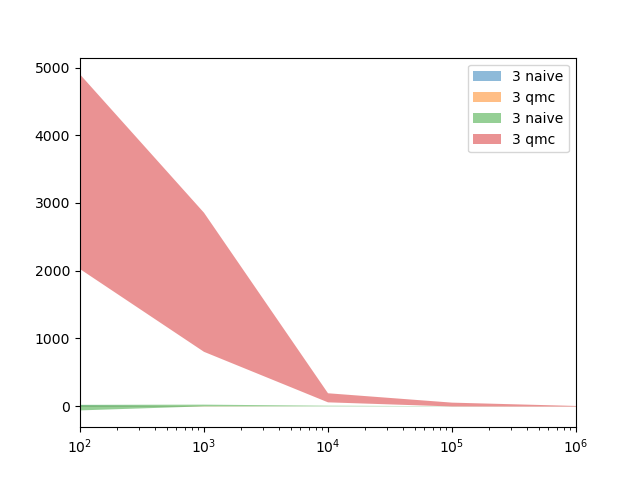

In [15]:
example_num = 3
N_mcs_vec = (10**(np.arange(2,7))).astype(int)
conf = np.zeros((N_mcs_vec.shape[0],2))
minmax=1
i_hyc = 3
uq_type = 1
fig, axes = plt.subplots(1,1,sharex=True, sharey=True)
axes = [axes,axes]
reference = [np.full((1,2), np.nan),
             np.full((2,2), np.nan),
             np.full((2,2), np.nan),
             np.full((4,2), np.nan),
             np.full((4,2), np.nan),]

for minmax in range(2):
    # plt.figure()   
    for example_num in range(3,4):
        for uq_type in range(2):
            for i_mcs in reversed(range(N_mcs_vec.shape[0])):
                # print(i_mcs)
                N_mcs = N_mcs_vec[i_mcs]
                this_focals = []
                for run_num in range(30):
                    this_result_dir = os.path.join(result_dir, f'{example_num}-{N_mcs}/{run_num}/')
                    if uq_type==0:
                        save_path = os.path.join(this_result_dir, 'naive_uq.npz')
                        focals_stats = np.load(save_path)['arr_0']
                    elif os.path.exists(os.path.join(this_result_dir, 'polyuq_inc.npz')):
                        inc_path = os.path.join(this_result_dir, 'polyuq_inc.npz')
                        focals_stats = np.load(inc_path, allow_pickle=True)['self.focals_stats'] * 1e4
                    else:
                        focals_stats = np.full((1,i_hyc+1,2), np.nan)

                    this_focals.append(focals_stats[0,i_hyc,:])

                this_focals = np.vstack(this_focals)
                
                if minmax==0:
                    data = np.nanmin(this_focals, axis=1)
                else:
                    data = np.nanmax(this_focals, axis=1)
                    
                conf[i_mcs,:] = scipy.stats.t.interval(confidence=0.95, df=len(data)-1, loc=np.mean(data), scale=scipy.stats.sem(data))
                if i_mcs == N_mcs_vec.shape[0]-1 and uq_type==0:
                    reference[example_num][i_hyc,minmax] = conf[i_mcs,:].mean()
                # print(reference[example_num][i_hyc,minmax])
                conf[i_mcs,:] -= reference[example_num][i_hyc,minmax]
            # else:
                # if minmax:
                #     print(example_num, '\n', focals_stats)
                # print(example_num, minmax, conf[i_mcs, :])
            axes[minmax].fill_between(N_mcs_vec, conf[:,0], conf[:,1], label=f'{example_num} ' + ['naive','qmc'][uq_type], alpha=0.5)
            # axes[minmax].plot(N_mcs_vec, np.abs(conf.mean(axis=1)), label=f'{example_num} ' + ['naive','qmc'][uq_type] + ' ' + ['min','max'][minmax], alpha=0.5)
plt.legend()
plt.xscale('log')
# plt.yscale('log')
plt.xlim(N_mcs_vec.min(),N_mcs_vec.max())
plt.show()

In [24]:
example_num = 4
for uq_type in range(2):
    for i_hyc in range(4):
        N_mcs = int(1e6)
        this_focals = []
        for run_num in range(30):
            this_result_dir = os.path.join(result_dir, f'{example_num}-{N_mcs}/{run_num}/')
            if uq_type==0:
                this_result_dir = os.path.join(result_dir, f'{example_num}-{N_mcs}_bak/{run_num}/')
                save_path = os.path.join(this_result_dir, 'naive_uq.npz')
                focals_stats = np.load(save_path)['arr_0']
            elif os.path.exists(os.path.join(this_result_dir, 'polyuq_inc.npz')):
                inc_path = os.path.join(this_result_dir, 'polyuq_inc.npz')
                focals_stats = np.load(inc_path, allow_pickle=True)['self.focals_stats'] * 1e4
            else:
                focals_stats = np.full((1,i_hyc+1,2), np.nan)

            this_focals.append(focals_stats[0,i_hyc,:])

        this_focals = np.vstack(this_focals)
        if uq_type==0:
            for minmax in range(4):
                data = this_focals[:,minmax]

                conf = scipy.stats.t.interval(confidence=0.95, df=len(data)-1, loc=np.mean(data), scale=scipy.stats.sem(data))

                print(i_hyc, ['impl-incl', 'impl-incu', 'impu-incl', 'impu-incu'][minmax], conf, f'{np.mean(conf):1.2f}', f'{conf[1]-np.mean(conf):1.2f}', f'({np.min(data):1.2f},{np.max(data):1.2f})')
        else:
            for minmax in range(2):
                if minmax==0:
                    data = np.nanmin(this_focals, axis=1)
                else:
                    data = np.nanmax(this_focals, axis=1)

                conf = scipy.stats.t.interval(confidence=0.95, df=len(data)-1, loc=np.mean(data), scale=scipy.stats.sem(data))

                print(i_hyc, ['min', 'max'][minmax], conf, f'{np.mean(conf):1.2f}', f'{conf[1]-np.mean(conf):1.2f}', f'({np.min(data):1.2f},{np.max(data):1.2f})')


0 impl-incl (9.93337444298441, 10.139958890348927) 10.04 0.10 (9.51,10.49)
0 impl-incu (nan, nan) nan nan (nan,nan)
0 impu-incl (nan, nan) nan nan (nan,nan)
0 impu-incu (nan, nan) nan nan (nan,nan)
1 impl-incl (7.616858699417572, 7.845807967249097) 7.73 0.11 (6.98,8.45)
1 impl-incu (13.170018137156319, 13.417315196177015) 13.29 0.12 (12.59,13.90)
1 impu-incl (nan, nan) nan nan (nan,nan)
1 impu-incu (nan, nan) nan nan (nan,nan)
2 impl-incl (3.572718247714078, 3.7012817522859227) 3.64 0.06 (3.35,3.97)
2 impl-incu (nan, nan) nan nan (nan,nan)
2 impu-incl (19.128558689525768, 19.343441310474233) 19.24 0.11 (18.31,19.65)
2 impu-incu (nan, nan) nan nan (nan,nan)
3 impl-incl (2.645473014741459, 2.775860318591875) 2.71 0.07 (2.37,3.08)
3 impl-incu (5.006505578531634, 5.174827754801701) 5.09 0.08 (4.69,5.63)
3 impu-incl (15.008181287566313, 15.291152045767031) 15.15 0.14 (14.25,15.84)
3 impu-incu (24.73275717530586, 25.092576158027473) 24.91 0.18 (23.93,25.94)
0 min (9.698632696611666, 10.57282

In [42]:
example_num = 4
N_mcs = 1000000
run_num=1
logger = logging.getLogger('uncertainty.polymorphic_uncertainty')
logger.setLevel(level=logging.INFO)

this_result_dir = os.path.join(result_dir, f'{example_num}-{N_mcs}/{run_num}/')

prop_path = os.path.join(this_result_dir, 'polyuq_prop.npz')
imp_path = os.path.join(this_result_dir, 'polyuq_imp.npz')
inc_path = os.path.join(this_result_dir, 'polyuq_inc.npz')

_, dim_ex, vars_ale, vars_epi, = [example_a, example_b, example_c, example_d, example_e][example_num]()

for var in vars_ale:
    display(var.support(percentiles=(0.000001, 0.999999)))
poly_uq = PolyUQ(vars_ale, vars_epi, dim_ex=dim_ex)
poly_uq.load_state(prop_path)
display(poly_uq.var_supp)
# poly_uq.sample_qmc(10, 10, percentiles=(0.000001, 0.999999), check_discr=False)
# display(poly_uq.var_supp)
poly_uq.load_state(imp_path, differential='imp')
poly_uq.load_state(inc_path, differential='inc')
# poly_uq.var_supp, poly_uq.inp_samp_prim.min(), poly_uq.inp_samp_prim.max()


Mixed Imprecision and Incompleteness example...


[-9.094107897791055, 38.664107897762875]

[-1.5068486176457974, 17.506848617634176]

[-0.980273944705832, -0.21972605529463296]

[-0.12287667397051882, 0.9228766739698796]

INFO:uncertainty.polymorphic_uncertainty:Loading previous results from  /usr/scratch4/sima9999/work/modal_uq/uq_simple_beam/4-1000000/1/polyuq_prop.npz


,q1,mu1,sig1,q2,dq2a0l,dq2a0r
0,-9.094108,13.96,3.66,-2.487123,-0.980274,-0.122877
1,38.664108,15.61,4.85,18.429725,-0.219726,0.922877


INFO:uncertainty.polymorphic_uncertainty:Loading previous results from  /usr/scratch4/sima9999/work/modal_uq/uq_simple_beam/4-1000000/1/polyuq_imp.npz
INFO:uncertainty.polymorphic_uncertainty:Loading previous results from  /usr/scratch4/sima9999/work/modal_uq/uq_simple_beam/4-1000000/1/polyuq_inc.npz


In [ ]:
poly_uq.inp_samp_prim

In [34]:
poly_uq.out_samp[270,947], (poly_uq.inp_samp_prim['q1'][270]*189/500+3*poly_uq.inp_samp_prim['q2'][947])*16/3,poly_uq.inp_samp_prim['q1'][270],poly_uq.inp_samp_prim['q2'][947]

(161.5979641129386, 161.5979641129386, -3.8054970057049253, 10.579365379777483)

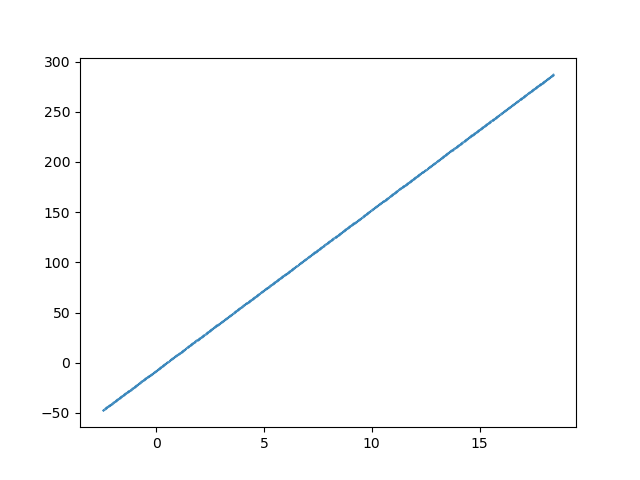

In [40]:
plt.figure()
plt.scatter(poly_uq.inp_samp_prim['q2'],poly_uq.out_samp[270,:], s=0.1)

In [36]:
poly_uq.imp_foc[270,...], poly_uq.val_samp_prim[270,...]

(array([[-15.64571745, -15.64571745],
        [-28.54223346,  -6.88464087]]),
 array([[[-0.49836472, -0.49836472],
         [        nan,         nan]],
 
        [[-1.30439697,  0.04920257],
         [        nan,         nan]]]))

In [37]:
poly_uq.inp_suppl_ale.iloc[270], poly_uq.inp_suppl_epi.iloc[270], poly_uq.inp_samp_prim.iloc[270]

(q2       -0.498365
 dq2a0l   -0.806032
 dq2a0r    0.548444
 Name: 270, dtype: float64,
 mu1     15.537473
 sig1     4.579199
 Name: 270, dtype: float64,
 q1   -3.805497
 q2   -0.498365
 Name: 270, dtype: float64)

In [ ]:
logger = logging.getLogger('uncertainty.polymorphic_uncertainty')
logger.setLevel(level=logging.INFO)
poly_uq.estimate_imp(
            interp_fun='nearest',
            opt_meth='Powell',
            plot_res=True,
            plot_intp=False,
            intp_err_warn = None,
            extrp_warn = 10,
            start_ale=270, end_ale=271,
            )

In [38]:
poly_uq.imp_foc[270,...]

array([[-15.64571745, -15.64571745],
       [-28.54223346,  -6.88464087]])

In [33]:
poly_uq.load_state(inc_path, differential='inc')
display(poly_uq.focals_stats)
logger = logging.getLogger('uncertainty.polymorphic_uncertainty')
logger.setLevel(level=logging.INFO)
focals_Pf, hyc_mass = poly_uq.optimize_inc(stat_fun, 1)
display(poly_uq.focals_stats)

INFO:uncertainty.polymorphic_uncertainty:Loading previous results from  /usr/scratch4/sima9999/work/modal_uq/uq_simple_beam/4-1000000/1/polyuq_inc.npz


array([[[1.00701891e-03, 1.00701891e-03],
        [7.52085697e-04, 1.41281301e-03],
        [1.42151953e-04, 2.73098280e-03],
        [9.99321366e-05, 3.36887631e-03]]])

INFO:uncertainty.polymorphic_uncertainty:Estimating incompleteness intervals by direct L-BFGS optimization of statistics over input hypercubes...
|████████████████████████████████████████| 4/4 [100%] in 11:02.1 (0.00/s)       


array([[[1.00701891e-03, 1.00701891e-03],
        [7.52085697e-04, 1.41281301e-03],
        [1.42151953e-04, 2.73098280e-03],
        [9.99321366e-05, 3.36887631e-03]]])

In [51]:
poly_uq.inc_hyc_foc_inds

[[0, 0], [1, 1]]

In [52]:
vars_inc = poly_uq.vars_inc
numeric_focals = [var.numeric_focals for var in vars_inc]

In [54]:
numeric_focals, [var.name for var in vars_inc]

([array([[14.79, 14.79],
         [13.96, 15.61]]),
  array([[4.17, 4.17],
         [3.66, 4.85]])],
 ['mu1', 'sig1'])

In [10]:
poly_uq.inp_suppl_ale.iloc[270]

q2        26.185379
dq2a0l    -0.640420
dq2a0r     0.628688
Name: 270, dtype: float64

In [11]:
poly_uq.var_supp

,q1,mu1,sig1,q2,dq2a0l,dq2a0r
0,-9.094108,13.96,3.66,-2.487123,-0.980274,-0.122877
1,38.664108,15.61,4.85,35.013697,-0.219726,0.922877
